<a href="https://colab.research.google.com/github/raki7315/Transfer-learning/blob/master/PNEUMONIADETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What is **Pneumonia**?
lung inflammation caused by bacterial or viral infection, in which the air sacs fill with pus and may become solid. Inflammation may affect both lungs (double pneumonia), one lung (single pneumonia), or only certain lobes (lobar pneumonia)

**Importing all the neccessary libraries.**

In [ ]:
#Importing all the neccessary libraries.
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers
from tensorflow.keras.optimizers import RMSprop
import seaborn as sns
import os
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array,array_to_img
from sklearn.metrics import confusion_matrix,classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


I've already downloaded the data from(kaggle)  [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) and stored in Google drive.
I'm accessing the data through drive by mounting on it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Desciption of Pneumonia Dataset**


Pneumonia dataset is organized in to 3 folders(**train,val,test**).Each folder consists of two sub-folders namely **NORMAL** and **PNEUMONIA** .Threre are a total of **5863** images(JPEG).All these images were graded by two expert physicians before being cleared for training the AI system.

## **Loading the Dataset and Preprocessing**

In [ ]:
#We are using ImageDataGenerator to load and Preprocess the data.
#Checking the Given data is balanced or not!!!

gen=ImageDataGenerator(rescale=1./255) #Creating a ImageDataGeneratot insatance which normaises(rescle=1./255) the image. 

train_generator=gen.flow_from_directory('/content/drive/My Drive/datasets/chest_xray/train',
                                        class_mode='binary',shuffle=False ) 

Found 8555 images belonging to 2 classes.


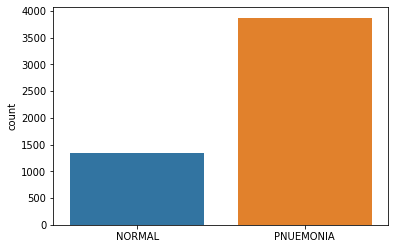

In [ ]:
x=[]
for i in train_generator.labels:
  if(i==0):
    x.append('NORMAL')    #NORMAL Means people with out PNEUMONIA
  else:
    x.append('PNUEMONIA')  #People with PNUEMONIA
    
sns.countplot(x)    #Visualising the proportion of images in each class of training data using seaborn countplot.

It seems that the data is **imbalanced**.For a better classifier we need atleast nearly balanced dataset.
So we use Data Augmentation to increase the size of the data of the deficit class(Categoty).If we don't balance the data,the classifier would be **biased** to the class that has more data,and predicts the given input towards the biased class.

We should makeup the **NORMAL** data to the  **PNUEMONIA** data

**Balancing the dataset Using the Data Augmentation**

In [ ]:
dir=pathlib.Path('/content/drive/My Drive/datasets/chest_xray/train/NORMAL')

#instantiating the path of the train data NORMAL directory

In [ ]:
count=0
for i in dir.iterdir():            #iterating through the directory and printing and all the paths and it's count(nothing but no.of images)
  count=count+1
  print(i)
print(count)

/content/drive/My Drive/datasets/chest_xray/train/NORMAL/IM-0523-0001-0001.jpeg
/content/drive/My Drive/datasets/chest_xray/train/NORMAL/IM-0523-0001-0002.jpeg
/content/drive/My Drive/datasets/chest_xray/train/NORMAL/IM-0524-0001.jpeg
/content/drive/My Drive/datasets/chest_xray/train/NORMAL/IM-0525-0001-0001.jpeg
/content/drive/My Drive/datasets/chest_xray/train/NORMAL/IM-0509-0001-0001.jpeg
/content/drive/My Drive/datasets/chest_xray/train/NORMAL/IM-0513-0001.jpeg
/content/drive/My Drive/datasets/chest_xray/train/NORMAL/IM-0519-0001-0001.jpeg
/content/drive/My Drive/datasets/chest_xray/train/NORMAL/IM-0525-0001-0002.jpeg
/content/drive/My Drive/datasets/chest_xray/train/NORMAL/IM-0509-0001-0002.jpeg
/content/drive/My Drive/datasets/chest_xray/train/NORMAL/IM-0529-0001.jpeg
/content/drive/My Drive/datasets/chest_xray/train/NORMAL/IM-0545-0001.jpeg
/content/drive/My Drive/datasets/chest_xray/train/NORMAL/IM-0553-0001-0002.jpeg
/content/drive/My Drive/datasets/chest_xray/train/NORMAL/IM-

We are instatiating a ImageDataGenerator,to generate the new data,using the existing data,by applying some transformations like rotating the image randomly,flipping the image from left to right,zooming the image.This process is called **Data Augmentation**.

In [ ]:
datagen=ImageDataGenerator( rotation_range=40,
                       width_shift_range=0.2,
                       horizontal_flip=True,
                       height_shift_range=0.2,
                       zoom_range=0.2)

**datagen.flow()** method empowers us to apply data augmentation on every image,and saves the newly generated images in the mentioned directory,in the specified format by mentioning in the save_format argument.This process will take some time,So be patient.

**NOTE:This step should be performed only once,If you do it multiple times(more than once),you would end up getting a completely imbalanced data**.**Because we** **are are storing the generated in the same parent(NORMAL) directory.**

In [ ]:
count=0
#The for is to loop through every every single image.

for item in dir.iterdir():
  i=0
  try:                  #we are using "try and except" method,to load the image and apply data augmentation on it.
    img=load_img(item)  #loads a image from the path mentioned
    x=img_to_array(img) #converts the image in to multi-dimentional array.
    x=x.reshape((1,) + x.shape) # reshapes in to the new dimention (1, shape of the image)

    
    #The .flow command below generates the batches of the randomly generated images and saves in the mentioned directory(We are storing in the same "NORMAL" directory of train data)
    
    for batch in datagen.flow(x,batch_size=1,save_to_dir='/content/drive/My Drive/datasets/chest_xray/train/NORMAL',save_prefix='NORMAL',save_format='jpeg' ):
        i+=1
        if(i==3):   #We are generating only 3 random images for every image
          break     #Other wise the generator would loop infinetely for a single image.
  except:
    print('There was an error opening the image.')     #If we couldn't load the image then,we would get this error message displayed.
  count+=1
print(count)


There was an error opening the image.
1342


**Observing the data after data augmentation.Expecting a pretty balanced data.**

In [ ]:
#We are using ImageDataGenerator to load and Preprocess the data.
#Checking the Given data is balanced or not!!!
gen=ImageDataGenerator(rescale=1./255)
train_generator=gen.flow_from_directory('/content/drive/My Drive/datasets/chest_xray/train',
                                        class_mode='binary',shuffle=False )

Found 8555 images belonging to 2 classes.


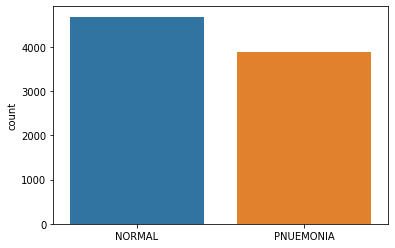

In [ ]:
x=[]
for i in train_generator.labels:
  if(i==0):
    x.append('NORMAL')
  else:
    x.append('PNUEMONIA')
    
sns.countplot(x) #Visualising the proportion of images in each class of training data using seaborn countplot.

**Preprocesing the data**


In [ ]:
gen_train=ImageDataGenerator( 
                       rescale=1./255,
                       rotation_range=40,
                       width_shift_range=0.2,
                       horizontal_flip=True,
                       height_shift_range=0.2,
                       zoom_range=0.2)
train_generator=gen_train.flow_from_directory('/content/drive/My Drive/datasets/chest_xray/train',
                                        batch_size=32,
                                        target_size=(300,300),      #Images have different shapes,for training purpose,we are reducing the size of all images to (300,300)
                                        class_mode='binary',shuffle=True)
val_generator=gen.flow_from_directory('/content/drive/My Drive/datasets/chest_xray/val',
                                      target_size=(300,300),shuffle=False,
                                      class_mode='binary')
test_generator=gen.flow_from_directory('/content/drive/My Drive/datasets/chest_xray/test',
                                       target_size=(300,300),shuffle=False,
                                       class_mode='binary')

Found 8555 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## **Building the Model**

We are using a concept called [Transfer Learning](https://cs231n.github.io/transfer-learning/) .In tranfer learning we use a pre-trained model on very large dataset.Any model(classifier) consists of Feature extracter,followed by classifier built on top of it.So,we use a pre-trained model as a feature extracter and then we build our own classifier on top of it.In this model we are using [ResNet](https://keras.io/api/applications/resnet/#resnet152v2-function) as our feature extracter,which was trained on Imagenet dataset of 1000 different classes

In [ ]:
base_model=tf.keras.applications.ResNet152V2(include_top=False,weights='imagenet',input_shape=(300,300,3))

#We make include_top=False,so that we get the only feature extracter part of the model.

#We make weights='imagenet'.This is to load the weights associated while training on imagenet dataset.

#We metion the input shape of the our dataset,using input_shape argument.

**NOTE:**We don't have to train the base_model while training with our dataset.Because,its already trained on a very large dataset.So,we make base_model.trainable=**False**.

In [ ]:
base_model.trainable=False

**Building the classifier on top of the base_model.**

In [ ]:
model=models.Sequential([
                         base_model,                           #base model,that we've discussed earlier.
                         layers.GlobalAveragePooling2D(),      #Global pooling layer.
                         layers.Dense(256,activation='relu'),  #Hidden dense layer with 256 nuerons.
                         layers.Dense(256,activation='relu'),  #Hidden dense layer with 256 nuerons.
                         layers.Dense(1,activation='sigmoid')  #Output layer with single nueron.One nueron is enough for binary classification problem.
])

**Summary of the model**

In [ ]:
model.summary()     #Display's each and every layer's description,like no.of parameters and output shape of each layer.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 10, 10, 2048)      58331648  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 58,922,241
Trainable params: 590,593
Non-trainable params: 58,331,648
_________________________________________________________________


**Compiling the model**

In [ ]:
model.compile(optimizer=RMSprop(0.0001),metrics=['accuracy'],loss='binary_crossentropy')

#We are using RMSprop as our optimizer and using "accuracy" as a metric to evaluate the model performance.
#We've taken learning rate=0.0001

## **Fitting(training) the Model**

To avoid the problem of overfitting and **unneccesary** training with no improvement,we use EarlyStopping method.

In [ ]:
history=model.fit(train_generator,steps_per_epoch=100,verbose=1,validation_data=val_generator,epochs=100,callbacks=  [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

#We are monitoring validation loss.(Our,aim is to decrease the validation loss)

#We mentioned patience=3.So,if there are 3 straight training epochs,with no decrease(improvement) in the validation loss,then training would come to an end.

Epoch 1/100
100/100 [==============================] - 139s 1s/step - loss: 0.4277 - accuracy: 0.8168 - val_loss: 0.3611 - val_accuracy: 0.8750
Epoch 2/100
100/100 [==============================] - 130s 1s/step - loss: 0.2740 - accuracy: 0.8949 - val_loss: 0.3465 - val_accuracy: 0.8750
Epoch 3/100
100/100 [==============================] - 126s 1s/step - loss: 0.2209 - accuracy: 0.9169 - val_loss: 0.2369 - val_accuracy: 0.9375
Epoch 4/100
100/100 [==============================] - 128s 1s/step - loss: 0.1881 - accuracy: 0.9225 - val_loss: 0.2425 - val_accuracy: 0.8750
Epoch 5/100
100/100 [==============================] - 123s 1s/step - loss: 0.1722 - accuracy: 0.9360 - val_loss: 0.3454 - val_accuracy: 0.8125
Epoch 6/100
100/100 [==============================] - 125s 1s/step - loss: 0.1586 - accuracy: 0.9472 - val_loss: 0.1825 - val_accuracy: 0.9375
Epoch 7/100
100/100 [==============================] - 121s 1s/step - loss: 0.1792 - accuracy: 0.9381 - val_loss: 0.2385 - val_accuracy:

**Evaluating the model on test data**

This is the final accuracy,our model has already seen train and validation data while training,but this is totally unseen data,this will help to figure out,how our would work when deployed in the real-world day-to-day application.

In [ ]:
eval=new_model.evaluate(test_generator) #evaluating on test data

20/20 [==============================] - 8s 413ms/step - loss: 0.1845 - accuracy: 0.9375


I've got an accuracy of **93.75%** on test data.You may not get the exact accuracy,because the weights are randomly initialized to the model while training.But you should get around **90%** accuracy on test data.

In [ ]:
print('Loss:{} and the Accuracy:{}%'.format(eval[0],eval[1]*100))

Loss:0.18449623882770538 and the Accuracy:93.75%


**Loss and Accuracy plots of training and validation data**

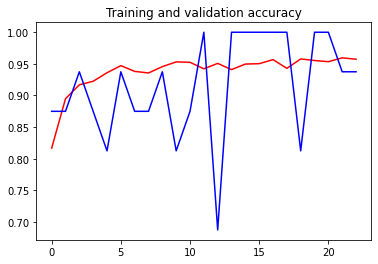

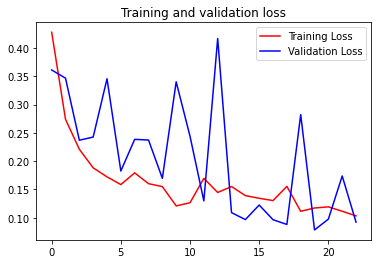

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## **Confusion Matrix**

In [ ]:
y_true=test_generator.labels      #Test data labels 

In [ ]:
y_pred=model.predict_classes(test_generator)     #Predicting on test data with our newly trained model.

In [ ]:
y=confusion_matrix(y_true,y_pred)

In [ ]:
y

array([[219,  15],
       [ 24, 366]])

In [ ]:
tn, fp, fn, tp = y.ravel()

In [ ]:
print('True Negative:{}\nFalse Positive:{}\nFalse Negative:{}\nTrue Positive:{}'.format(tn,fp,fn,tp))

True Negative:219
False Positive:15
False Negative:24
True Positive:366


CONFUSION MATRIX

![Confusion matrix](https://miro.medium.com/max/1106/1*vMEqRXTl8PRfRtgWgwUVEg.jpeg) 

In our classification problem,**Positive(1)** class is people with **PNEUMONIA** and the **Negative(0)** class is people **without PNEUMONIA** i.e normal condition.

**True Positive(TP)**:Data actually belongs to **positive(1)** class and our model aslo predicts it as **positive(1)** class.

**True Negative(TN)**:Data actually belongs to **negative(0)** class and our model aslo predicts it as **negative(0)** class.

**False Positive(FP)**:Data actually belongs to **negative(0)** class,but our model predicts it as **positive(1)** class.So,it is an error.

**False Negative(FN)**:Data actually belongs to **positive(1)** class,but our model predicts it as **negative(0)** class.So,it is also an error.

**NOTE:**Confusin matrix is extremely helpful,to know how the model is working.We always must try to keep **False Negative(FN)** as low as possible especially in **medical** field.Because,

Let's take an example,you bulit a model that predicts whether a person has cancer or not.(Positive:with cancer and Negative:without cancer)

It's ok to tell a person you've tested **positive** for cancer,eventhough he doesn't really have cancer.(which is nothing but **False positive(FP)**).

But it's terrible to tell a person you've tested **negative** for cancer,eventhough he really posses cancer in his body.Because,here we are decreasing the chances of him to get treated and get cured.(which is nothing but **False negative(FN)**).

##**Complete Classification report**

In [ ]:
print(classification_report(y_true, y_pred, target_names = ['Normal  (Class 0)','Pneumonia(Class 1)']))

                    precision    recall  f1-score   support

 Normal  (Class 0)       0.90      0.94      0.92       234
Pneumonia(Class 1)       0.96      0.94      0.95       390

          accuracy                           0.94       624
         macro avg       0.93      0.94      0.93       624
      weighted avg       0.94      0.94      0.94       624



## **Saving and Retrieving the model that we trained.**

In [ ]:
!mkdir -p saved_model                             #make a new directory to store your models.
model.save('drive/My Drive/saved_model/my_model')  #Saving our model in the given directory,with the name as my_model

INFO:tensorflow:Assets written to: drive/My Drive/saved_model/my_model/assets


In [ ]:
new_model=models.load_model('drive/My Drive/saved_model/my_model')  #retreiving the our saved model.

In [ ]:
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 10, 10, 2048)      58331648  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 58,922,241
Trainable params: 58,778,497
Non-trainable params: 143,744
_________________________________________________________________


In [ ]:
eval=new_model.evaluate(test_generator) #evaluating on test data

20/20 [==============================] - 9s 426ms/step - loss: 0.1845 - accuracy: 0.9375


In [ ]:
print('Loss:{} and the Accuracy:{}%'.format(eval[0],eval[1]*100))

Loss:0.18449623882770538 and the Accuracy:93.75%
